In [38]:
import pandas as pd  
import numpy as np
import ydata_profiling
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                    cross_val_score
import os

In [39]:
filepath = os.path.abspath(".")
initial_df = pd.read_csv(rf'{filepath}\train.csv')
submission_df = pd.read_csv(rf'{filepath}\test.csv')

In [40]:
initial_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Data preproccesing - Fill NaN values

In [41]:
initial_df['Age'] = initial_df['Age'].fillna(0)
# initial_df['Cabin'] = initial_df['Cabin'].fillna(0)
initial_df['Fare'] = initial_df['Fare'].fillna(0)

# transformer tous les champs en des numériques

In [42]:
features=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
initial_with_dummies_df = pd.get_dummies(initial_df[features + ['Survived']])

In [43]:
ydata_profiling.ProfileReport(initial_with_dummies_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

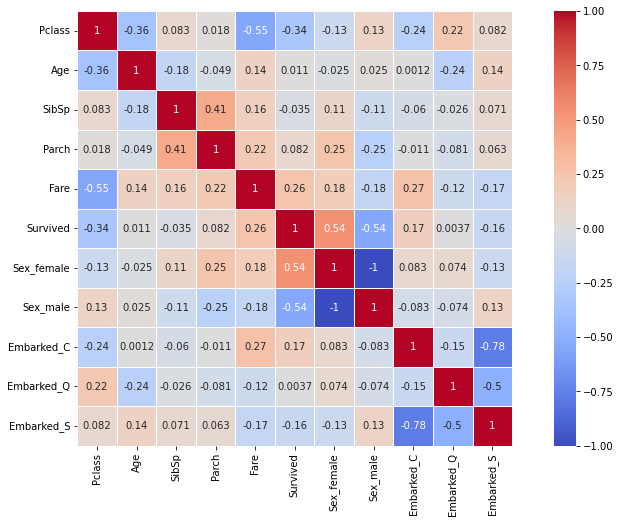

In [44]:
# Matrice des corrélations : 
cor = initial_with_dummies_df.corr() 

sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.5,annot=True)
plt.gcf().set_size_inches(15, 8)

#Pour choisr la couleur du heatmap : https://matplotlib.org/examples/color/colormaps_reference.html

Modélisation : Training DecisionTreeClassifier

In [45]:
#On stocke survived (la variable à prédire) dans cible
cible = np.array(initial_with_dummies_df['Survived'])
#On supprime survived du dataset
initial_with_dummies_df = initial_with_dummies_df.drop('Survived', axis = 1)
#On conserve les noms de variable à part
liste_variables = list(initial_with_dummies_df.columns)
#On convertit le dataset en array
initial_with_dummies_df = np.array(initial_with_dummies_df)

Split du dataset en train et test

In [46]:
#On créé 4 dataset : 
#   - x_train contient 75% de x  
#   - y_train contient le survived associé à x_train
# => x_train et y_train permettront d'entraîner l'algorithme
#
#   - x_test contient 25% de x  
#   - y_test contient le survived associé à x_test
# => x_test et y_test permettront d'évaluer la performance de l'algorithme une fois entrainé sur le train
x_train,x_test,y_train,y_test=train_test_split(initial_with_dummies_df,cible,test_size=0.25, shuffle=False, random_state=0)

Apprentissage

In [47]:
#On importe l'algorithme à partir de sklearn
from sklearn.tree import DecisionTreeClassifier
#On créé un Random Forest de 100 arbres 
model = DecisionTreeClassifier(random_state = 0)
#Et on lance le training sur notre dataset de train
model = model.fit(x_train, y_train)

[Text(0.4387907608695652, 0.9736842105263158, 'X[6] <= 0.5\ngini = 0.475\nsamples = 668\nvalue = [408, 260]'),
 Text(0.15434782608695652, 0.9210526315789473, 'X[0] <= 2.5\ngini = 0.384\nsamples = 243\nvalue = [63, 180]'),
 Text(0.0782608695652174, 0.868421052631579, 'X[4] <= 149.035\ngini = 0.103\nsamples = 128\nvalue = [7, 121]'),
 Text(0.06086956521739131, 0.8157894736842105, 'X[4] <= 28.856\ngini = 0.082\nsamples = 117\nvalue = [5, 112]'),
 Text(0.05217391304347826, 0.7631578947368421, 'X[4] <= 28.231\ngini = 0.165\nsamples = 55\nvalue = [5, 50]'),
 Text(0.043478260869565216, 0.7105263157894737, 'X[1] <= 27.5\ngini = 0.137\nsamples = 54\nvalue = [4, 50]'),
 Text(0.02608695652173913, 0.6578947368421053, 'X[1] <= 25.0\ngini = 0.227\nsamples = 23\nvalue = [3, 20]'),
 Text(0.017391304347826087, 0.6052631578947368, 'X[1] <= 23.5\ngini = 0.091\nsamples = 21\nvalue = [1, 20]'),
 Text(0.008695652173913044, 0.5526315789473685, 'gini = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(0.02608695652

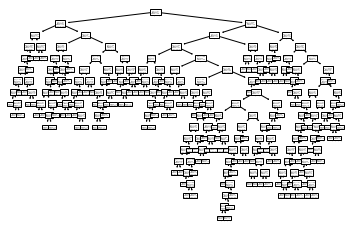

In [48]:
from sklearn import tree
tree.plot_tree(model)

In [49]:
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("DecisionTreeClassifier_TreeDesign_Titanic") 

'DecisionTreeClassifier_TreeDesign_Titanic.pdf'

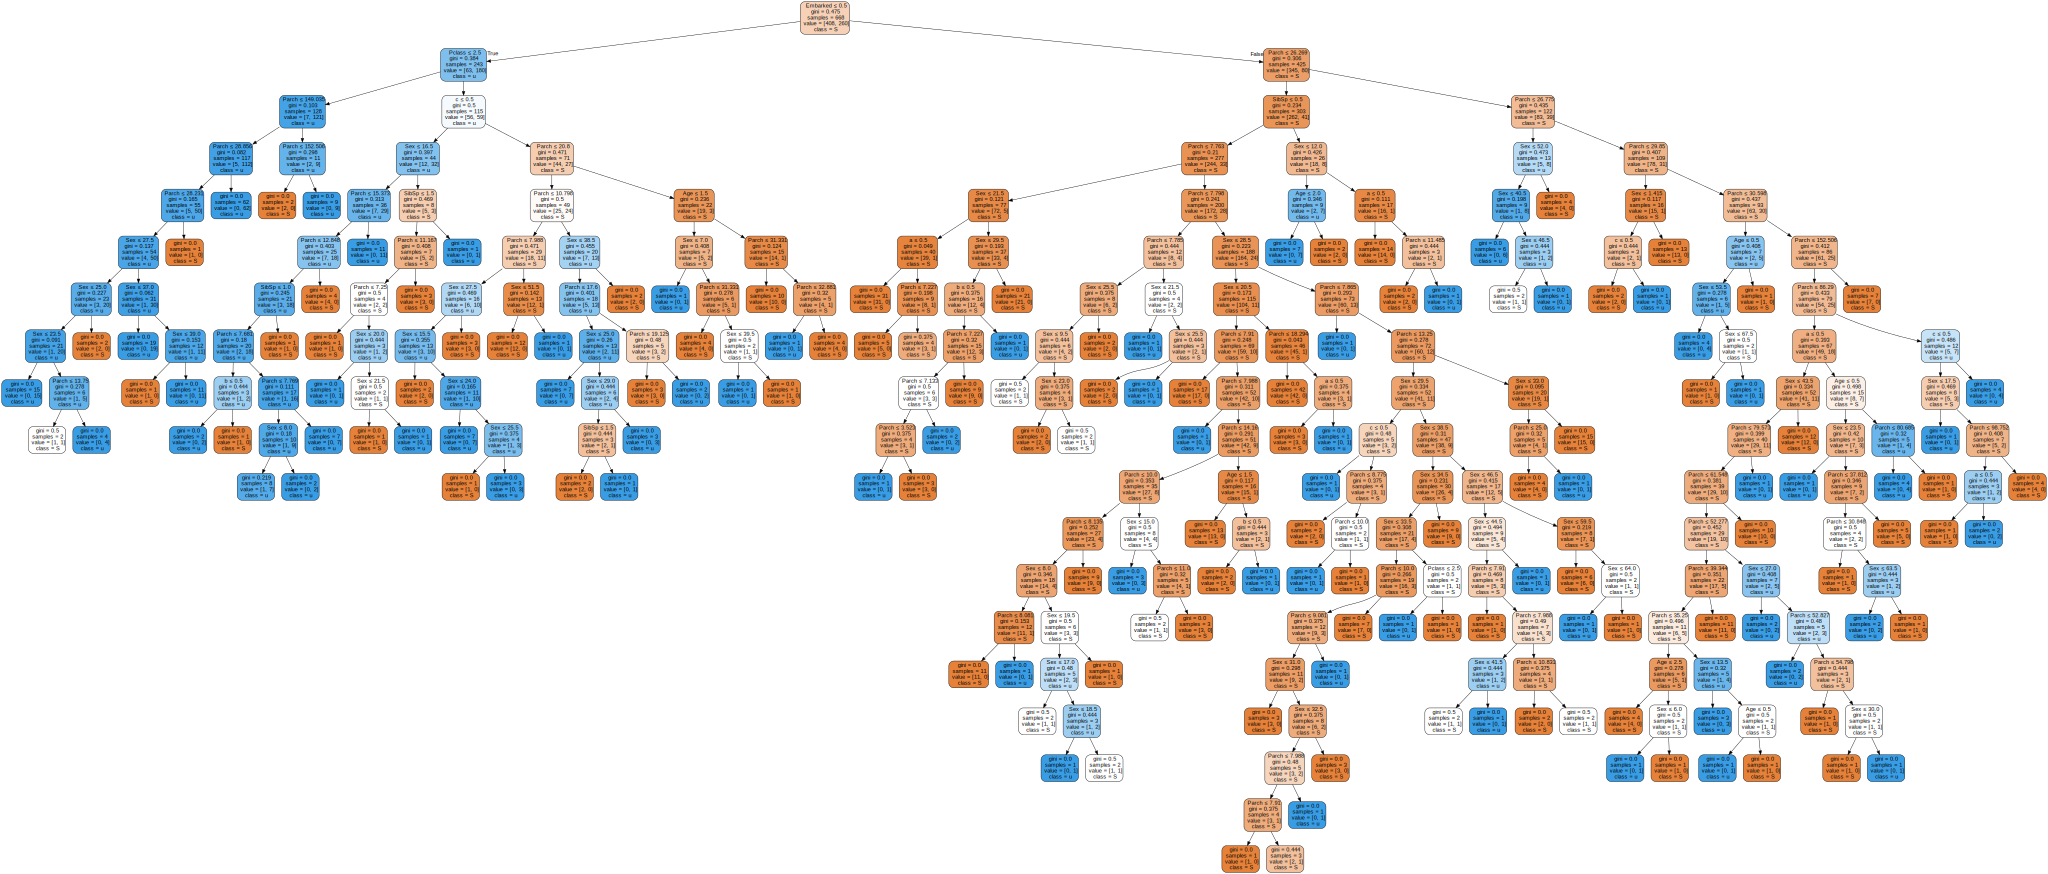

In [50]:
dot_data = tree.export_graphviz(model, out_file=None, 
                      feature_names=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked','a','b','c'],  
                      class_names='Survived',  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# Test

In [58]:
#On applique le modèle que l'on vient 
#d'entraîner sur l'échantillon de test
predictions = model.predict(x_test)
#print(predictions)

In [52]:
cv_test = cross_val_score(model, x_test, y_test, cv=5).mean().round(5)
model_score = model.score(x_test, y_test).round(5)    

In [53]:
data={'Model':'DecisionTreeClassifier','Cross_Validation':cv_test,'Accuracy':model_score}
df=pd.DataFrame(data=data,index=[1])
df

,Model,Cross_Validation,Accuracy
1,DecisionTreeClassifier,0.75343,0.77578


# Confusion Matrix

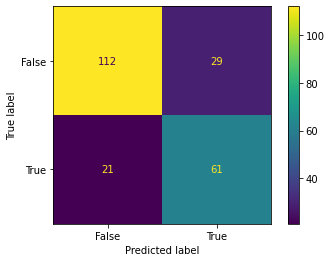

In [54]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

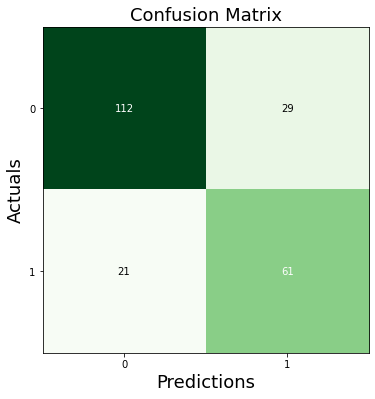

In [56]:
#!pip install mlxtend

from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Accuracy
Précision
La précision mesure la fréquence à laquelle le modèle est correct.

Comment calculer
(Vrai positif + Vrai négatif) / Prédictions totales

In [ ]:
Accuracy = metrics.accuracy_score(y_test, predictions)
print(Accuracy)


0.7757847533632287


# Précision
Parmi les positifs prédits, quel pourcentage est vraiment positif ?

Comment calculer: 

Vrai positif / (vrai positif + faux positif)

La précision n'évalue pas les cas négatifs correctement prédits :

In [ ]:
Precision = metrics.precision_score(y_test, predictions)
print(Precision)

0.6777777777777778


# Sensibilité 
Parmi tous les cas positifs, quel pourcentage sont prédits positifs ?

La sensibilité (parfois appelée rappel) mesure la capacité du modèle à prédire les positifs.

Cela signifie qu'il examine les vrais positifs et les faux négatifs (qui sont des positifs qui ont été incorrectement prédits comme négatifs).

In [ ]:
Sensitivity_recall = metrics.recall_score(y_test, predictions)
print(Sensitivity_recall)

0.7439024390243902


# Spécificité

Dans quelle mesure le modèle prédit-il des résultats négatifs ?

La spécificité est similaire à la sensibilité, mais la considère du point de vue des résultats négatifs.

Comment calculer
Vrai négatif / (vrai négatif + faux positif)

Comme c'est juste l'opposé de Recall, nous utilisons la fonction rappel_score, en prenant l'étiquette de position opposée :

In [ ]:
Specificity = metrics.recall_score(y_test, predictions, pos_label=0)
print(Specificity)

0.7943262411347518


# Note F
Le score F est la "moyenne harmonique" de la précision et de la sensibilité.

Il prend en compte à la fois les cas de faux positifs et de faux négatifs et convient aux ensembles de données déséquilibrés.

Comment calculer
2 * ((Précision * Sensibilité) / (Précision + Sensibilité))

Ce score ne prend pas en compte les valeurs True Negative :

In [ ]:
F1_score = metrics.f1_score(y_test, predictions)
print(F1_score)

0.7093023255813954


In [ ]:
data={'Model':'DecisionTreeClassifier','Cross_Validation':cv_test,'Accuracy':model_score,'Précision': Precision,'Sensibilité':Sensitivity_recall,'Specificité':Specificity,'Note F': F1_score}
df=pd.DataFrame(data=data,index=[1])
df

,Model,Cross_Validation,Accuracy,Précision,Sensibilité,Specificité,Note F
1,DecisionTreeClassifier,0.75343,0.77578,0.677778,0.743902,0.794326,0.709302
